# Pipelines to evaluate fine-mapping benchmarks

This document contains several workflows to extract results from fine-mapping benchmarks and make plots for (mostly) SuSiE manuscript.

In [ ]:
[global]
parameter: cwd = path('~/GIT/lab-dsc/dsc-finemap')
parameter: version = '20190610'
# set to 0 to use estimated prior, or another number to use specified prior
# as configured in the DSC
parameter: susie_prior = [0.1, 0.0]
# null weight options to evaluate
parameter: null_weight = [0.0]
parameter: output_dir = path(f'{cwd:a}/output/susie_paper')

def fmtP(x):
    return str(x).replace(".", "p")

## Query results

In [ ]:
[pip_1, cali_1, roc_1]
depends: R_library('tibble')
output: f'{output_dir}/result_{version}.rds'
R: expand = '${ }', workdir = cwd
    library(tibble)
    dap_out = dscrutils::dscquery(${output_dir:r},
                        targets = c("small_data.dataset", "lm_pve02.meta", "lm_pve02.n_signal", 
                                  "score_dap.total", "score_dap.valid", "score_dap.size", "score_dap.avgr2", 
                                  "score_dap.top", "score_dap.overlap", "score_dap.signal_pip", "score_dap.pip"))
    susie_out = dscrutils::dscquery(${output_dir:r},
                        targets = c("small_data.dataset", "lm_pve02.meta", "lm_pve02.n_signal", "susie.prior_var", "susie.null_weight", 
                                  "score_susie.total", "score_susie.valid", "score_susie.size", "score_susie.purity", "score_susie.top", 
                                  "score_susie.objective", "score_susie.converged", "score_susie.overlap", "score_susie.signal_pip", "score_susie.pip"))
    caviar_out = dscrutils::dscquery(${output_dir:r},
                        targets = c("small_data.dataset", "lm_pve02.meta", "lm_pve02.n_signal", "caviar_in_sample.args", 
                                  "score_caviar.total", "score_caviar.valid", "score_caviar.size", " score_caviar.signal_pip", "score_caviar.pip"))
    finemap_out = dscrutils::dscquery(${output_dir:r},
                        targets = c("small_data.dataset", "lm_pve02.meta", "lm_pve02.n_signal", "finemap_in_sample.args", 
                                  "score_finemap.total", "score_finemap.valid", "score_finemap.size", "score_finemap.signal_pip", "score_finemap.pip"))
    rename_cols = function(dat) {
      for (item in names(dat)) {
          tmp = strsplit(colnames(dat[[item]]), "[.]")
          colnames(dat[[item]]) = unlist(lapply(1:length(tmp), function(i) ifelse(length(tmp[[i]])>1, tmp[[i]][2], tmp[[i]][1])))
      }
      return(dat)
    }
    # remove module names from column names; this is Okay because every column field here are unique
    res = rename_cols(list(dap=as_tibble(dap_out), susie=as_tibble(susie_out), caviar=as_tibble(caviar_out), finemap=as_tibble(finemap_out)))
    saveRDS(res, ${_output:r})

## PIP extraction

In [ ]:
[pip_2, cali_2, roc_2]
depends: R_library('tibble'), R_library('dplyr')
input: for_each = ['susie_prior', 'null_weight']
output: f'{_input:n}_prior_{fmtP(_susie_prior)}_null_{fmtP(_null_weight)}.rds'
R: stdout = f'{_output:n}.log', expand = '${ }', workdir = cwd
    dat = readRDS(${_input:r})
    dap_out = dat$dap
    caviar_out = dat$caviar
    susie_out = dat$susie
    finemap_out = dat$finemap
    # favorit susie flavor
    susie_out = susie_out[which(susie_out$prior_var == ${_susie_prior} & susie_out$null_weight == ${_null_weight}), ]
    # and for the rest of the PIP analysis we pool across all data-set
    # but we evaluate for each number of signals settings
    # PVE is fixed to 0.2 here using `lm_pve02` module
    data_sets = unique(susie_out$dataset)
    n_signals = unique(susie_out$n_signal)
    result = list()
    for (s in n_signals) {
        result[[as.character(s)]] = NULL
        if (s > 3) {
            has_caviar = FALSE
        } else {
            has_caviar = TRUE
        }
        print(paste('==============', s, '=============='))
        for (d in data_sets) {
            # should all be one row
            susie_row = susie_out[which(susie_out$n_signal == s & susie_out$dataset == d), ]
            dap_row = dap_out[which(dap_out$n_signal == s & dap_out$dataset == d), ]
            if (nrow(susie_row) != 1 || nrow(dap_row) != 1) stop("Rows are not unique for susie & dap")
            if (has_caviar) {
              caviar_row = caviar_out[which(caviar_out$n_signal == s & caviar_out$dataset == d & caviar_out$args == paste('-g 0.001 -c', s)), ]
              finemap_row = finemap_out[which(finemap_out$n_signal == s & finemap_out$dataset == d & finemap_out$args == paste('--n-causal-max', s)), ]
              if (nrow(caviar_row) != 1 || nrow(finemap_row) != 1) stop("Rows are not unique for caviar & finemap")
            }
            # a slightly awkward yet convenient syntax thanks to tibble format
            truth = susie_row$meta[[1]]$true_coef
            for (r in 1:ncol(truth)) {
              susie_pip = susie_row$pip[[1]][,r]
              dap_pip = dap_row$pip[[1]][,r]
              if (has_caviar) {
                  caviar_pip = caviar_row$pip[[1]][,r]
                  finemap_pip = finemap_row$pip[[1]][,r]
                  pip = cbind(susie_pip, dap_pip, caviar_pip, finemap_pip, truth[,r] != 0)
              } else {
                  pip = cbind(susie_pip, dap_pip, truth[,r] != 0)
              }
              # remove all zero PIP / table
              pip = pip[rowSums(pip) > 0, ]
              ## BEGIN debug
              outlier = pip[which(pip[,1] < 0.1 & pip[,2]>0.6), ,drop=F]
              if (nrow(outlier)>0 && s <= 2) {
                print("DAP outlier")
                print(c(r,d))
              }
              if (has_caviar && s == 1) {
                conflict = pip[which(pip[,1] < 0.95 & pip[,3] > 0.95), ,drop=F]
                if (nrow(conflict) > 0) {
                    print("CAVIAR-susie conflict")
                    print(d)
                    print(pip[conflict,])
                    print("CAVIAR")
                    print(which(caviar_pip>0.95))
                    print("SuSiE")
                    print(which(susie_pip>0.95))
                }
                outlier = pip[which(pip[,1] > 0.1 & pip[,3] < 0.1), ,drop=F]
                if (nrow(outlier)>0 && s <= 2) {
                    print("SuSiE outlier")
                    print(c(r,d))
                }
              }
              ## END debug
              if (is.null(result[[as.character(s)]])) {
                  result[[as.character(s)]] = pip
              } else {
                  result[[as.character(s)]] = rbind(result[[as.character(s)]], pip)
              }
           }
        }
        result[[as.character(s)]] = data.frame(result[[as.character(s)]])
        if (has_caviar) {
            colnames(result[[as.character(s)]]) = c('susie', 'dap', 'caviar', 'finemap', 'is_signal')
        } else {
            colnames(result[[as.character(s)]]) = c('susie', 'dap', 'is_signal')
        }
    }
    saveRDS(result, ${_output:r})

## PIP direct comparison

In [ ]:
[pip_3]
comparisons = ['susie_vs_dap', 'susie_vs_caviar', 'susie_vs_finemap', 'dap_vs_caviar', 'dap_vs_finemap', 'caviar_vs_finemap']
input: group_by = 1, concurrent = True
output: paths([f'{_input:n}.{x}.png' for x in comparisons])
R: expand = '${ }'
    result = readRDS(${_input:r})
    merge_img = function(prefix, n) {
        files = paste0(prefix, '_', seq(1:n), '.png')
        cmd = paste('convert +append', paste(files, collapse=" "), paste0(prefix, '.png'))
        system(cmd)
        system(paste('rm -f', paste(files, collapse=" ")))
        files = paste0(prefix, '_', seq(1:n), '.md')
        cmd = paste('cat', paste(files, collapse=" "), '>', paste0(prefix, '.md'))
        system(cmd)
        system(paste('rm -f', paste(files, collapse=" ")))
    }

    merge_lists = function(lists) {
        lists = do.call(rbind,lapply(cbind(lists), unlist))
        names = colnames(lists)
        lists = lapply(1:ncol(lists), function(i) lists[,i])
        names(lists) = names
        return(lists)
    }

    plot_pip = function(x, n_causal, s, output_prefix, xname, yname, xlab, ylab, pip_cutoff = -1, pip_diff_categories = c(0.1, 0.15, 0.2)) {
      x = x[x[[xname]] > pip_cutoff & x[[yname]] > pip_cutoff,]
      if (pip_cutoff >=0) {
          xlab = paste0(xlab, ">", pip_cutoff)
          ylab = paste0(ylab, ">", pip_cutoff)
      }
      colors = sapply(1:length(x$is_signal), function(i) ifelse(x$is_signal[i],'#800000','#002b36'))
      # compute difference in pip and proportions
      pip_diff = abs(x[[xname]] - x[[yname]])
      pip_diff_cnts = sapply(pip_diff_categories, function(x) length(which(pip_diff >= x)))
      pip_diff_text = vector()
      for (i in 1:length(pip_diff_categories)) {
          tmp = paste0('- ', pip_diff_cnts[i], '/', length(pip_diff), ' (', formatC(pip_diff_cnts[i] / length(pip_diff) * 100, format = "e", digits = 2), '%) differ by ', pip_diff_categories[i])
          pip_diff_text = c(pip_diff_text, tmp)
      }
      pip_diff_text = paste(pip_diff_text, collapse = '\n')
      corr_text = paste('- correlation', round(cor(x)[1,2],2))
      header = paste('#', xname, 'vs', yname, s, n_causal, 'causal\n')
      pdf(paste0(output_prefix, '_', n_causal, '.pdf'), width=5, height=5, pointsize=14)
      plot(x[[xname]], x[[yname]], xlab = xlab, ylab = ylab,
         main = paste0(n_causal, s , ifelse(n_causal>1, ' effect variables', ' effect variable')),
         col = colors, pch = 20, cex = 1.4, bty='l')
      abline(0,1,col=2)
      #abline(h=0.95, col='gray')
      #abline(v=0.95, col='gray')
      dev.off()
      system(paste0("convert -flatten -density 120 ", paste0(output_prefix, '_', n_causal, '.pdf'), " ", paste0(output_prefix, '_', n_causal, '.png')))
      write(paste(header, corr_text, pip_diff_text, '\n', sep = '\n'), paste0(output_prefix, '_', n_causal, '.md'))
    }
    result_1 = result[[1]]
    result_2 = result[[2]]
    result_3 = result[[3]]
    result_5 = do.call(rbind, lapply(3:5, function(i) result[[i]][,c('susie','dap', 'is_signal')]))
    # susie vs dap
    plot_pip(result_1, 1, '', ${_output[0]:nr}, 'susie', 'dap', 'PIP SuSiE', 'PIP DAP-G')
    plot_pip(result_2, 2, '', ${_output[0]:nr}, 'susie', 'dap', 'PIP SuSiE', 'PIP DAP-G')
    plot_pip(result_5, 3, ' ~ 5', ${_output[0]:nr}, 'susie', 'dap', 'PIP SuSiE', 'PIP DAP-G')
    merge_img(${_output[0]:nr}, 3)
    # susie vs caviar
    plot_pip(result_1, 1, '', ${_output[1]:nr}, 'susie', 'caviar', 'PIP SuSiE', 'PIP CAVIAR')
    plot_pip(result_2, 2, '', ${_output[1]:nr}, 'susie', 'caviar', 'PIP SuSiE', 'PIP CAVIAR')
    plot_pip(result_3, 3, '', ${_output[1]:nr}, 'susie', 'caviar', 'PIP SuSiE', 'PIP CAVIAR')
    merge_img(${_output[1]:nr}, 3)
    # susie vs finemap
    plot_pip(result_1, 1, '', ${_output[2]:nr}, 'susie', 'finemap', 'PIP SuSiE', 'PIP FINEMAP')
    plot_pip(result_2, 2, '', ${_output[2]:nr}, 'susie', 'finemap', 'PIP SuSiE', 'PIP FINEMAP')
    plot_pip(result_3, 3, '', ${_output[2]:nr}, 'susie', 'finemap', 'PIP SuSiE', 'PIP FINEMAP')
    merge_img(${_output[2]:nr}, 3)
    # dap vs caviar
    plot_pip(result_1, 1, '', ${_output[3]:nr}, 'dap', 'caviar', 'PIP DAP-G', 'PIP CAVIAR')
    plot_pip(result_2, 2, '', ${_output[3]:nr}, 'dap', 'caviar', 'PIP DAP-G', 'PIP CAVIAR')
    plot_pip(result_3, 3, '', ${_output[3]:nr}, 'dap', 'caviar', 'PIP DAP-G', 'PIP CAVIAR')
    merge_img(${_output[3]:nr}, 3)
    # dap vs finemap
    plot_pip(result_1, 1, '', ${_output[4]:nr}, 'dap', 'finemap', 'PIP DAP-G', 'PIP FINEMAP')
    plot_pip(result_2, 2, '', ${_output[4]:nr}, 'dap', 'finemap', 'PIP DAP-G', 'PIP FINEMAP')
    plot_pip(result_3, 3, '', ${_output[4]:nr}, 'dap', 'finemap', 'PIP DAP-G', 'PIP FINEMAP')
    merge_img(${_output[4]:nr}, 3)
    # caviar vs finemap
    plot_pip(result_1, 1, '', ${_output[5]:nr}, 'caviar', 'finemap', 'PIP CAVIAR', 'PIP FINEMAP')
    plot_pip(result_2, 2, '', ${_output[5]:nr}, 'caviar', 'finemap', 'PIP CAVIAR', 'PIP FINEMAP')
    plot_pip(result_3, 3, '', ${_output[5]:nr}, 'caviar', 'finemap', 'PIP CAVIAR', 'PIP FINEMAP')
    merge_img(${_output[5]:nr}, 3)

## PIP calibration

In [ ]:
[cali_3]
bin_size = 20    
pip_cutoff = 0
input: concurrent = True
output: f'{_input:n}.calibration.rds'
R: stdout = f'{_output:n}.log', expand = '${ }', workdir = cwd
    dat = readRDS(${_input:r})
    pip_cali = list()
    bins = cbind(seq(1:${bin_size})/${bin_size}-1/${bin_size}, seq(1:${bin_size})/${bin_size})
    for (s in 1:length(dat)) {
          res = dat[[as.character(s)]]
          pip_cali[[as.character(s)]] = list()
          for (name in rev(colnames(res))[-1]) {
              for (i in 1:nrow(bins)) {
                  tmp = res[which(res[[name]] > bins[i,1] & res[[name]] < bins[i,2]),]
                  if (is.null(pip_cali[[as.character(s)]][[name]])) pip_cali[[as.character(s)]][[name]] = c(sum(tmp[[name]]), sum(tmp$is_signal), length(tmp$is_signal))
                  else pip_cali[[as.character(s)]][[name]] = rbind(pip_cali[[as.character(s)]][[name]], c(sum(tmp[[name]]), sum(tmp$is_signal), length(tmp$is_signal)))
              }
              pip_cali[[as.character(s)]][[name]][which(is.na(pip_cali[[as.character(s)]][[name]]))] = 0
          }
    }
    get_cali = function(alist, col) {
      res = alist[[1]][[col]]
      for (i in 2:length(alist)) {
          if (!is.null(alist[[i]][[col]])) res = res + alist[[i]][[col]]
      }
      res[,c(1,2)] = res[,c(1,2)] / res[,3]
      return(res[-1,])
    }
    saveRDS(list("SuSiE"=get_cali(pip_cali, 'susie'), 
                  "DAP-G"=get_cali(pip_cali, 'dap'), 
                  "CAVIAR"=get_cali(pip_cali, 'caviar'), 
                  "FINEMAP"=get_cali(pip_cali, 'finemap')), 
                  ${_output:r})

In [ ]:
[cali_4]
depends: executable('convert')
input: concurrent = True
output: f'{_input:n}.png'
R: stdout = f'{_output:n}.log', expand = '${ }', workdir = cwd
    library(ggplot2)
    library(cowplot)
    dot_plot = function(dataframe) {
        ggplot(dataframe, aes(x=mean_pip, y=observed_freq)) + 
          geom_errorbar(aes(ymin=observed_freq-se, ymax=observed_freq+se), colour="gray", size = 0.2, width=.01) +
          geom_point(size=1.5, shape=21, fill="#002b36") + # 21 is filled circle
          xlab("Mean PIP") +
          ylab("Observed frequency") +
          coord_cartesian(ylim=c(0,1), xlim=c(0,1)) +
          geom_abline(slope=1,intercept=0,colour='red', size=0.2) +
          ggtitle(name) +
          expand_limits(y=0) +                        # Expand y range
          theme_cowplot()
    }

    dat = readRDS(${_input:r})
    idx = 0
    for (name in names(dat)) {
      idx = idx + 1
      dat[[name]][,3] = sqrt(dat[[name]][,2] * (1 - dat[[name]][,2]) / dat[[name]][,3]) * 2
      dat[[name]] = as.data.frame(dat[[name]])
      colnames(dat[[name]]) = c("mean_pip", "observed_freq", "se")
      pdf(paste0(${_output:nr}, '_' , idx, '.pdf'), width=3, height=3, pointsize=16)
      print(dot_plot(dat[[name]]))
      dev.off()
      system(paste0("convert -density 120 ", ${_output:nr}, '_' , idx, '.pdf', " ", ${_output:nr}, '_' , idx, '.png'))
    }
    files = paste0(${_output:nr}, '_', seq(1:idx), '.png')
    cmd = paste('convert +append', paste(files, collapse=" "), ${_output:r})
    system(cmd)
    system(paste('rm -f', paste(files, collapse=" ")))

> /home/gaow/GIT/lab-dsc/dsc-finemap/output/susie_paper/result_20190610_prior_0p1_null_0p0.calibration.png (39.4 KiB):

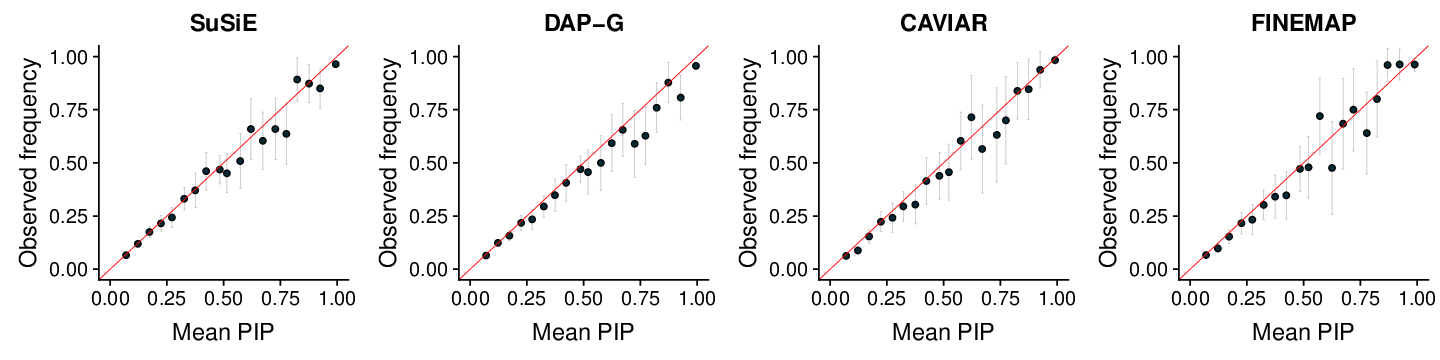

In [1]:
%preview /home/gaow/GIT/lab-dsc/dsc-finemap/output/susie_paper/result_20190610_prior_0p1_null_0p0.calibration.png

## ROC based on PIP 

In [ ]:
[roc_3]
pip_cutoff = 0.3
dap_cluster_cutoff = ('cluster_prob', 0.95)
input: concurrent = True
output: f'{_input:n}.roc_two.rds', f'{_input:n}.roc_all.rds'
R: stdout = f'{_output[0]:n}.log', expand = '${ }', workdir = cwd
    roc_data = function(d1, cutoff = c(${pip_cutoff}, 1), connect_org = TRUE) {
        grid = 500
        ttv = seq(1:grid)/grid
        ttv = ttv[which(ttv>=cutoff[1] & ttv<=cutoff[2])]
        # see SuSiE-Manuscript issue 2
        d1 = d1[order(d1[,1]), ]
        end = tail(d1[which(d1[,2] == 0),][,1],1)
        ttv = c(ttv[-length(ttv)], min(ttv[length(ttv)], end))
        # end of issue 2
        rst1 = t(sapply(ttv, function(x) c(sum(d1[,2][d1[,1]>=x]), length(d1[,2][d1[,1]>=x]))))
        rst1 = cbind(rst1, sum(d1[,2]))
        if (connect_org) {
            # connect to origin
            last_row = tail(rst1, 1)
            rst1 = rbind(rst1, c(last_row[1], last_row[2]-1, last_row[3]), c(0.001,0.001,last_row[3]))
        }
        rst1 = as.data.frame(rst1)
        colnames(rst1) = c('true_positive', 'total_positive', 'total_signal')
        if (connect_org) {
            rst2 = as.data.frame(cbind(rst1$true_positive / rst1$total_positive, rst1$true_positive / rst1$total_signal,  c(ttv, ttv[length(ttv)], 1)))
        } else {
            rst2 = as.data.frame(cbind(rst1$true_positive / rst1$total_positive, rst1$true_positive / rst1$total_signal,  ttv))
        }
        colnames(rst2) = c('Precision', 'Recall', 'Threshold')
        return(list(counts = rst1, rates = rst2))
    }
    
    print("Computing ROC data ...")
    result = readRDS(${_input:r})
    susie = roc_data(do.call(rbind, lapply(1:length(result), function(i) cbind(result[[i]]$susie, result[[i]]$is_signal))))
    dap = roc_data(do.call(rbind, lapply(1:length(result), function(i) cbind(result[[i]]$dap, result[[i]]$is_signal))), cutoff = c(${pip_cutoff}, 0.9999), connect_org = FALSE) # DAP output format has numerical artifect
    saveRDS(list(susie = susie, dap = dap), ${_output[0]:r})
    #
    susie = roc_data(do.call(rbind, lapply(1:3, function(i) cbind(result[[i]]$susie, result[[i]]$is_signal))))
    dap = roc_data(do.call(rbind, lapply(1:3, function(i) cbind(result[[i]]$dap, result[[i]]$is_signal))), cutoff = c(${pip_cutoff}, 0.9999), connect_org = FALSE)
    caviar = roc_data(do.call(rbind, lapply(1:3, function(i) cbind(result[[i]]$caviar, result[[i]]$is_signal))))
    finemap = roc_data(do.call(rbind, lapply(1:3, function(i) cbind(result[[i]]$finemap, result[[i]]$is_signal))))
    saveRDS(list(susie=susie, dap=dap, finemap=finemap, caviar=caviar), ${_output[1]:r})

In [ ]:
[roc_4]
chunks = 0
smooth = 'FALSE'
opt1 = "lwd = 2, xlim = c(0,0.2), ylim = c(0,0.2)"
opt2 = "lwd = 2, xlim = c(0,0.3), ylim = c(0,0.3)"
input: group_by = 2, concurrent = True
output: f'{_input[0]:nn}.roc.png'
R: expand = '${ }'
    colors = c('#A60628', '#7A68A6', '#348ABD', '#467821', '#FF0000', '#188487', '#E2A233',
                  '#A9A9A9', '#000000', '#FF00FF', '#FFD700', '#ADFF2F', '#00FFFF')
    d1 = readRDS(${_input[0]:r})
    d2 = readRDS(${_input[1]:r})
    library(scam)
    create_chunks = function(item, n) {
      splitted = suppressWarnings(split(item, 1:n))
      return(c(splitted[[1]], splitted[[length(splitted)]][length(splitted[[length(splitted)]])]))
    }
    make_smooth = function(x,y,subset=${chunks}, smooth = ${smooth}) {
      if (smooth) {
          if (subset < length(x) && subset > 0) {
              x = create_chunks(x, subset)
              y = create_chunks(y, subset)
          }
          dat = data.frame(cbind(x,y))
          colnames(dat) = c('x','y')
          y=predict(scam(y ~ s(x, bs = "mpi"), data = dat))
      }
      return(list(x=x,y=y))
    }
    add_text = function(thresholds, x, y, threshold, color, delta = 0.015) {
        idx = which(thresholds == threshold)
        text(x[idx] - delta, y[idx], labels = threshold, col = color)
        points(x[idx],y[idx])
    }
    pdf("${_output:n}.part1.pdf", width=5, height=5, pointsize=15)
    yy = make_smooth(1 - d1$susie$rates$Precision, d1$susie$rates$Recall)
    plot(yy$x, yy$y, t="l", col=colors[1], ylab = "power", xlab ="FDR", main = "1 ~ 5 effect variables", bty='l', ${opt1})
    add_text(d1$susie$rates$Threshold, yy$x, yy$y, 0.9, colors[1])
    add_text(d1$susie$rates$Threshold, yy$x, yy$y, 0.95, colors[1])
    # lines(1 - d2$susie$rates$Precision, d2$susie$rates$Recall, col=colors[2])
    yy = make_smooth(1 - d1$dap$rates$Precision, d1$dap$rates$Recall)
    lines(yy$x, yy$y, col=colors[3], ${opt1})
    add_text(d1$dap$rates$Threshold, yy$x, yy$y, 0.9, colors[3], -0.015)
    add_text(d1$dap$rates$Threshold, yy$x, yy$y, 0.95, colors[3], -0.015)
    # legend("bottomright", legend=c("SuSiE", "SuSiE (penalized)", "DAP-G"),
    legend("bottomright", legend=c("SuSiE", "DAP-G"),
       col=colors[c(1,3)], lty=c(1,1,1), cex=0.8)
    dev.off()
    system(paste0("convert -density 120 ", ${_output:nr}, '.part1.pdf', " ", ${_output:nr}, '.part1.png'))
    pdf("${_output:n}.part2.pdf", width=5, height=5, pointsize=15)
    yy = make_smooth(1 - d2$susie$rates$Precision, d2$susie$rates$Recall)
    plot(yy$x, yy$y, t="l", 
     col=colors[1], ylab = "power", xlab ="FDR", 
     main = "1 ~ 3 effect variables", bty='l', ${opt2})
    yy = make_smooth(1 - d2$dap$rates$Precision, d2$dap$rates$Recall)
    lines(yy$x, yy$y,col=colors[3], ${opt2})
    yy = make_smooth(1 - d2$caviar$rates$Precision, d2$caviar$rates$Recall)
    lines(yy$x, yy$y,col=colors[4], ${opt2})
    yy = make_smooth(1 - d2$finemap$rates$Precision, d2$finemap$rates$Recall)
    lines(yy$x, yy$y,col=colors[7], ${opt2})
    legend("bottomright", legend=c("SuSiE", "DAP-G", "CAVIAR", "FINEMAP"),
       col=c(colors[1], colors[3], colors[4], colors[7]), lty=c(1,1,1), cex=0.8)
    dev.off()
    system(paste0("convert -density 120 ", ${_output:nr}, '.part2.pdf', " ", ${_output:nr}, '.part2.png'))
  
bash: expand = True
  convert +append {_output:n}.part1.png {_output:n}.part2.png {_output:n}.png

> /home/gaow/GIT/lab-dsc/dsc-finemap/output/susie_paper/result_20190610_prior_0p1_null_0p0.roc_two.roc.png (39.9 KiB):

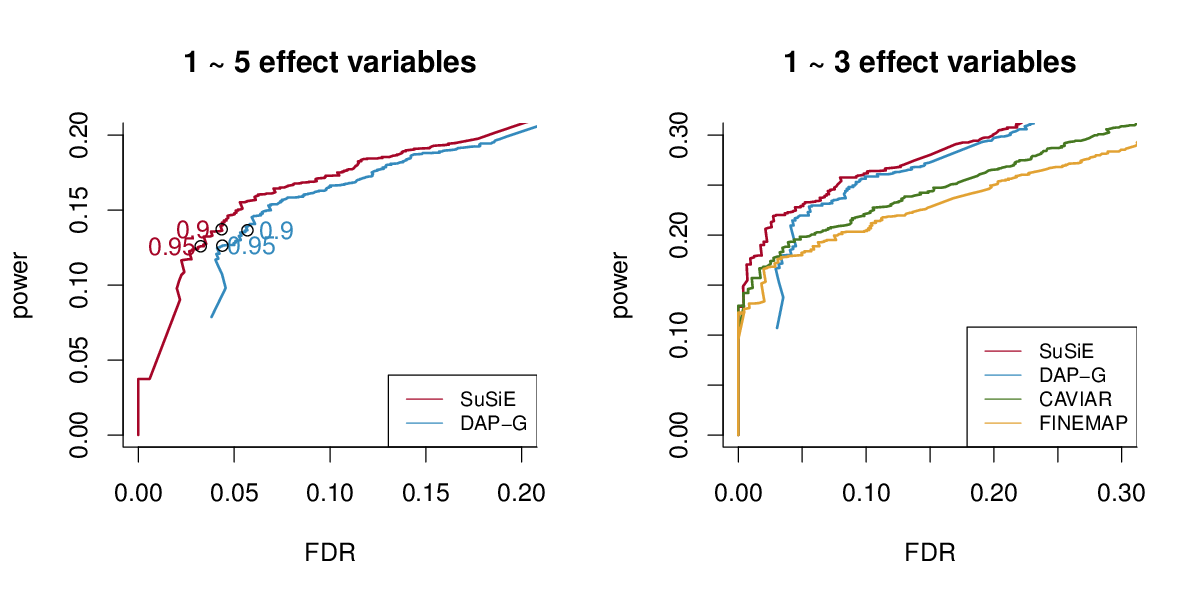

In [2]:
%preview /home/gaow/GIT/lab-dsc/dsc-finemap/output/susie_paper/result_20190610_prior_0p1_null_0p0.roc.png

> /home/gaow/GIT/lab-dsc/dsc-finemap/output/susie_paper/result_20190610_prior_0p0_null_0p0.roc_two.roc.png (39.9 KiB):

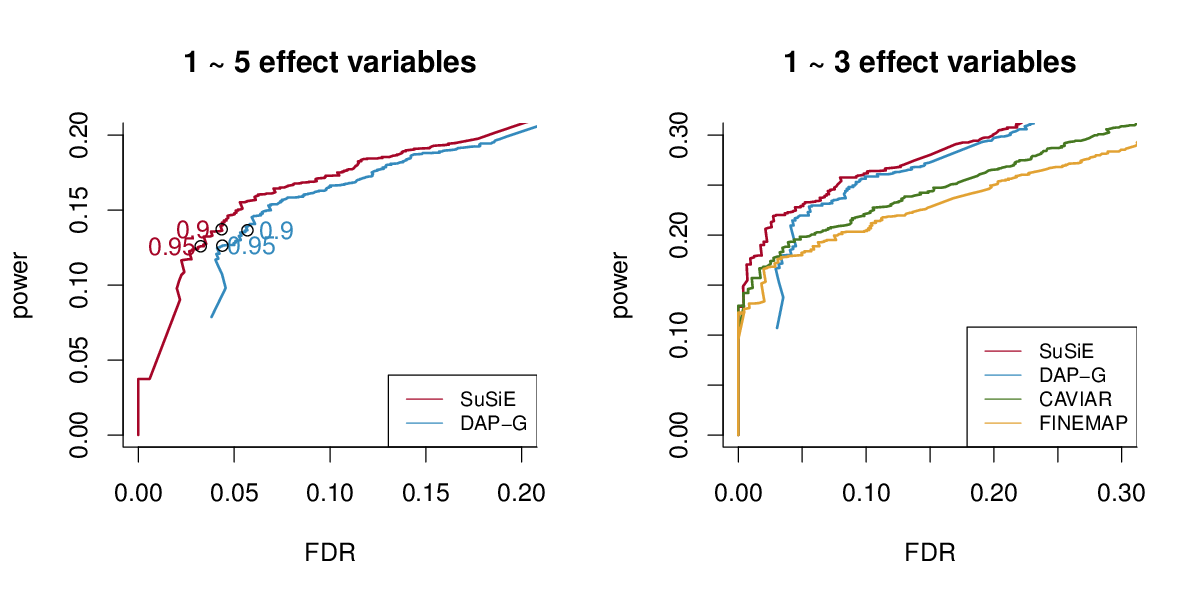

In [3]:
%preview /home/gaow/GIT/lab-dsc/dsc-finemap/output/susie_paper/result_20190610_prior_0p0_null_0p0.roc.png

## CS comparison

## CS coverage